In [2]:
%matplotlib inline
import json
import os
import math
from collections import OrderedDict
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path
from data import CodesInDbs, Mappings, Databases
from IPython.display import Latex

pd.set_option('display.max_colwidth', 100)

sns.set_style('whitegrid')
sns.set_context("paper", font_scale=2)
#plt.rcParams['figure.figsize'] = (4, 3)
#plt.rc("savefig", dpi=150)

measures_palette = sns.color_palette('Set1', n_colors=2, desat=.5)
measures_palette.reverse()

def graded_recall_palette(n_colors, rev=True):
    palette = sns.color_palette("Blues", n_colors=n_colors, desat=.6)
    if rev:
        palette.reverse()
    return palette

def graded_precision_palette(n_colors, rev=True):
    palette = sns.color_palette("Reds", n_colors=n_colors, desat=.6)
    if rev:
        palette.reverse()
    return palette

def mystyle(palette=None, xrot=0, ha='center', ylim=(0,1), ylabel=None, savefig=None):
    class C:
        def __enter__(self):
            if palette is not None:
                palette.__enter__()
        def __exit__(self, exc_type, value, traceback):
            if palette is not None:
                palette.__exit__(exc_type, value, traceback)
            if exc_type is None:
                ax = plt.gca()
                sns.despine(left=True, ax=ax)
                ax.grid(False, axis='x')
                if ax.legend_: 
                    lgd = ax.legend(loc=2, bbox_to_anchor=(1, 1))
                else:
                    lgd = None
                if ax.get_lines():
                    ax.get_lines()[0].set_visible(False)
                ax.set_ylim(*ylim)
                plt.xticks(rotation=xrot, ha=ha)
                if ylabel is not None:
                    ax.yaxis.label(ylabel)
                if savefig:
                    filename = '{}-{}'.format(PROJECT, savefig)
                    plt.savefig(filename, bbox_extra_artists=[lgd] if lgd else [], bbox_inches='tight')
    return C()

def draw_lines(ys, palette=None):
    if palette is None:
        palette = sns.color_palette()
    ax = plt.gca()
    ax.axhline(0, 0, 0) # First axhline is not visible??
    for y, color in zip(ys, palette):
        ax.axhline(y, color=color, zorder=-100)
    return ax

"""
pd.set_option('display.notebook_repr_html', True)
def _repr_latex_(self):
    #return r"\begin{center}%s\end{center}" % 
    return self.to_latex()
pd.DataFrame._repr_latex_ = _repr_latex_  # monkey patch pandas DataFrame
"""

PROJECT = os.getenv('COMAP_PROJECT')
print("PROJECT:", PROJECT)

PROJECT: safeguard


In [97]:
with open('../projects/{}/variations.yaml'.format(PROJECT)) as f:
    variations = yaml.load(f)

with open('../projects/{}/config.yaml'.format(PROJECT)) as f:
    config = yaml.load(f)
    databases = Databases.of_config(config)
    coding_systems = config['coding-systems']

with open('../projects/{}/events.yaml'.format(PROJECT)) as f:
    events = yaml.load(f)
    event_names = {}
    for event in events:
        casedef = yaml.load(open('../projects/{}/case-definitions/{}.yaml'.format(PROJECT, event)))
        event_names[event] = casedef['name']

with open('../projects/{}/mappings.yaml'.format(PROJECT)) as f:
    mappings = Mappings.of_raw_data_and_normalize(yaml.load(f), events, databases).normalize(databases)

with open('../codes-in-dbs.json') as f:
    codes_in_dbs = CodesInDbs.of_data(json.load(f))

coding_systems = ["ICD-9", "ICD-10", "ICPC-2", "READ-2"]
    
def database_label(database):
    #return database
    #return "{} ({})".format(database, databases.coding_system(database))
    return {
        "ICD10CM": "ICD-10",
        "ICD10/CM": "ICD-10",
        "RCD2": "READ-2",
        "ICPC2EENG": "ICPC-2",
        "ICD9CM": "ICD-9",
    }[databases.coding_system(database)]

def measure_label(measure):
    return {
        "recall": "Sensitivity",
        "precision": "PPV", # "Positive predictive value",
    }[measure]

def event_label(event):
    return event_names[event]

def len_if_notnull(x):
    if x != x:
        return 0
    else:
        return len(x)

## Load evaluations `ev`

In [84]:
ev = pd.read_csv('../{}.evaluations.csv'.format(PROJECT))
for key in ['generated', 'reference', 'tp', 'fp', 'fn']:
    ev[key] = ev[key].map(lambda x: x if x != x else json.loads(x))
ev['variation event database recall precision'.split()].head()

,variation,event,database,recall,precision
0,max-recall,pc,IPCI,1.00000,0.500000
1,max-recall,pc,GePaRD,1.00000,0.214286
2,max-recall,pc,CPRD,0.93578,0.910714
3,max-recall,pc,Medicare,1.00000,0.242424
4,max-recall,is,IPCI,1.00000,1.000000


## Mappings

In [85]:
df = mappings.describe()
df.index = df.index.map(database_label)
df.columns = df.columns.map(event_label)
df['Sum'] = df.iloc[:4,:7].sum(axis=1)
df['Average'] = df.iloc[:4,:7].mean(axis=1).round(2)
df.ix['Sum'] = df.iloc[:4, :7].sum()
df.ix['Average'] = df.iloc[:4, :7].mean().round(2)
df.ix['Sum']['Sum'] = df['Sum'].sum()
df.ix['Average']['Average'] = df['Average'].mean()
df.fillna('-').T

,READ-2,ICD-10,ICPC-2,ICD-9,Sum,Average
Acute Pancreatitis,7,6,1,1,15,3.75
Bladder cancer,91,12,1,12,116,29
Hemorrhagic stroke,36,22,1,3,62,15.5
Ischemic stroke,20,11,2,10,43,10.75
Myocardial Infarction,-,7,1,11,19,6.33
Pancreatic Cancer,109,9,1,8,127,31.75
Ventricular Arrhythmia,27,5,1,5,38,9.5
Sum,290,72,8,50,420,-
Average,48.33,10.29,1.14,7.14,-,16.725


# Notes

#### Should exclusion codes from the reference be generated?

No. Exclusion codes are often added database specifically, where the codes are *not* represented in the case definition.

# Coding systems

In [13]:
pd.DataFrame([
    (database, databases.coding_system(database), database_label(database))
    for database in databases.databases()
], columns=("Database", "Coding system", "Label")).set_index("Database")

,Coding system,Label
Database,,
Medicare,ICD9CM,ICD-9
IPCI,ICPC2EENG,ICPC-2
CPRD,RCD2,READ-2
GePaRD,ICD10/CM,ICD-10


## Baseline-0

### DISO filtering for concepts

In [86]:
types_distr = pd.DataFrame(json.load(open('../{}.types-distrs.json'.format(PROJECT)))).T

df = pd.DataFrame()
df['All'] = types_distr.groupby('group')[['pos', 'neg']].sum().sum()
df['All %'] =  df['All'] / df['All'].sum()
df['DISO'] = types_distr.groupby('group')[['pos', 'neg']].sum().ix['DISO']
df['DISO %'] = df['DISO'] / df['DISO'].sum()
df

,All,All %,DISO,DISO %
pos,19,0.069597,17,0.309091
neg,254,0.930403,38,0.690909


In [87]:
df = ev[ev.variation == 'baseline0'][['event', 'database', 'generated', 'reference', 'tp', 'fp', 'fn']]
for key in 'generated reference tp fp fn'.split():
    df[key] = df[key].map(len_if_notnull)
df['database'] = df['database'].map(database_label)
df.groupby('database').sum()

,generated,reference,tp,fp,fn
database,,,,,
ICD-10,32,72,15,17,57
ICD-9,24,50,10,14,40
ICPC-2,7,8,4,3,4
READ-2,64,290,24,40,266


,ICD-9,ICD-10,ICPC-2,READ-2,Average
Sensitivity,0.316,0.249,0.5,0.132,0.299
PPV,0.486,0.606,0.7,0.347,0.535


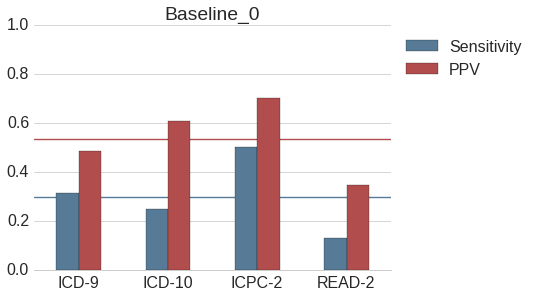

In [20]:
df = pd.DataFrame([
    ev[ev.variation == 'baseline0'].groupby('database').recall.mean(),
    ev[ev.variation == 'baseline0'].groupby('database').precision.mean(),
])
df.index = df.index.map(measure_label)
df.columns = df.columns.map(database_label)
df = df[coding_systems]
df['Average'] = df.mean(axis=1)

with mystyle(measures_palette, savefig='baseline-performance-by-db.pdf'):
    with sns.plotting_context(font_scale=1):
        ax = draw_lines(df['Average'])
        df.iloc[:,:-1].T.plot(kind='bar', title='Baseline_0', ax=ax)
        
df.round(3)

# Baseline

In [98]:
df = ev[ev.variation == 'baseline'][['event', 'database', 'generated', 'reference', 'tp', 'fp', 'fn']]
for key in 'generated reference tp fp fn'.split():
    df[key] = df[key].map(len_if_notnull)
df['database'] = df['database'].map(database_label)
df.groupby('database').sum()

,generated,reference,tp,fp,fn
database,,,,,
ICD-10,32,72,15,17,57
ICD-9,23,50,10,13,40
ICPC-2,6,8,4,2,4
READ-2,50,290,22,28,268


,ICD-9,ICD-10,ICPC-2,READ-2,Average
Sensitivity,0.316,0.249,0.5,0.124,0.297
PPV,0.514,0.606,0.7,0.458,0.570


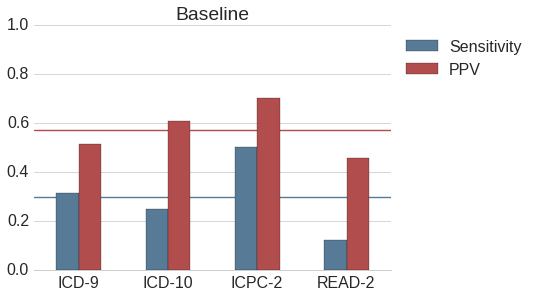

In [26]:
df = pd.DataFrame([
    ev[ev.variation == 'baseline'].groupby('database').recall.mean(),
    ev[ev.variation == 'baseline'].groupby('database').precision.mean(),
])
df.index = df.index.map(measure_label)
df.columns = df.columns.map(database_label)
df = df[coding_systems]
df['Average'] = df.mean(axis=1)

with mystyle(measures_palette, savefig='baseline-performance-by-db.pdf'):
    with sns.plotting_context(font_scale=1):
        ax = draw_lines(df['Average'])
        df.iloc[:,:-1].T.plot(kind='bar', title='Baseline', ax=ax)

df.round(3)

,Acute Pancreatitis,Bladder cancer,Hemorrhagic stroke,Ischemic stroke,Myocardial Infarction,Pancreatic Cancer,Ventricular Arrhythmia,Average
Sensitivity,0.399,0.408,0.120,0.170,0.537,0.373,0.178,0.312
PPV,0.222,0.531,0.556,0.667,0.806,1.000,0.175,0.565


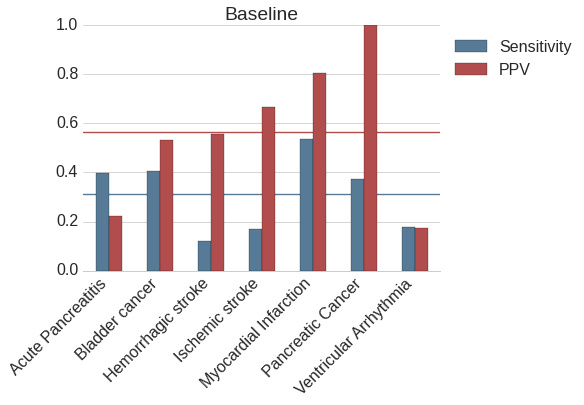

In [27]:
df = pd.DataFrame([
    ev[ev.variation == 'baseline'].groupby('event').recall.mean(),
    ev[ev.variation == 'baseline'].groupby('event').precision.mean(),
])
df.index = df.index.map(measure_label)
df.columns = df.columns.map(event_label)
df['Average'] = df.mean(axis=1)

with mystyle(measures_palette, xrot=45, ha='right', savefig='baseline-performance-by-event.pdf'):
    ax = draw_lines(df['Average'])
    df.iloc[:,:-1].T.plot(kind='bar', title='Baseline', ax=ax)
    
df.round(3)

# Max-recall

In [101]:
df = ev[ev.variation == 'max-recall'][['event', 'database', 'generated', 'reference', 'tp', 'fp', 'fn']]
for key in ['generated', 'reference', 'tp', 'fp', 'fn']:
    df[key] = df[key].map(len_if_notnull)
df['database'] = df['database'].map(database_label)
df = df.groupby('database').sum()
df.ix['Overall'] = df.sum()
df['fn/reference'] = df['fn'] / df['reference']
#df['tp/generated'] = 1 - (df.tp / df.generated).round(3)
df.round(3)

,generated,reference,tp,fp,fn,fn/reference
database,,,,,,
ICD-10,148,72,72,76,0,0.000
ICD-9,107,50,50,57,0,0.000
ICPC-2,10,8,8,2,0,0.000
READ-2,295,290,269,26,21,0.072
Overall,560,420,399,161,21,0.050


,ICD-9,ICD-10,ICPC-2,READ-2,Average
Sensitivity,1.000,1.000,1.000,0.930,0.982
PPV,0.612,0.607,0.857,0.899,0.744


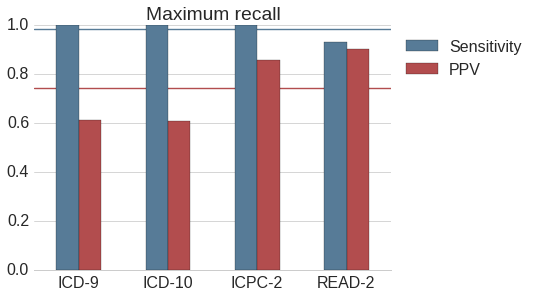

In [102]:
df = pd.DataFrame([
    ev[ev.variation == 'max-recall'].groupby('database').recall.mean(),
    ev[ev.variation == 'max-recall'].groupby('database').precision.mean(),
])
df.index = df.index.map(measure_label)
df.columns = df.columns.map(database_label)
df = df[coding_systems]
df['Average'] = df.mean(axis=1)

with mystyle(measures_palette, ylim=(0,1), savefig='max-recall-performance-by-db.pdf'):
    ax = draw_lines(df['Average'])
    df.iloc[:,:-1].T.plot(kind='bar', title='Maximum recall', ax=ax)
    
df.round(3)

,ICD-9,ICD-10,ICPC-2,READ-2,Average
Sensitivity,1,1,1,0.93,0.982


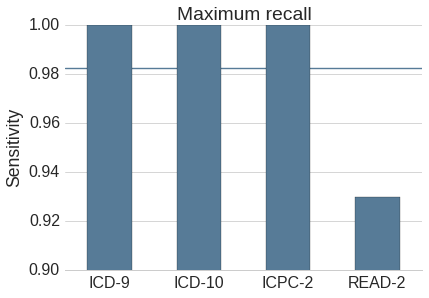

In [103]:
df = pd.DataFrame([
    ev[ev.variation == 'max-recall'].groupby('database').recall.mean(),
])
df.index = df.index.map(measure_label)
df.columns = df.columns.map(database_label)
df = df[coding_systems]
df['Average'] = df.mean(axis=1)

with mystyle(measures_palette, ylim=(.9, 1), savefig='max-recall-recall-by-db.pdf'):
    ax = draw_lines(df['Average'])
    df.iloc[:,:-1].T.plot(kind='bar', legend=False, title='Maximum recall', ax=ax)
    plt.ylabel(measure_label('recall'))
    
df.round(3)

## Reasons for imperfect sensitivity

In [110]:
with open('../{}.code-stats.csv'.format(PROJECT)) as f:
    code_stats = pd.read_csv(f)
    
stats = pd.DataFrame()
stats['Mapping'] = (code_stats[code_stats.InMapping]
                    .groupby('Database')
                    .Code.count())
stats['Not maximum-recall'] = (code_stats[code_stats.InMapping & ~code_stats.InDnf]
                               .groupby('Database')
                               .Code.count())
stats = stats.fillna(0)
stats['% of missing'] = (stats['Not maximum-recall'] / stats['Not maximum-recall'].sum()).map("{:.2%}".format)
stats['% of mapping'] = (stats['Not maximum-recall'] / stats['Mapping']).map("{:.2%}".format)
stats.index = stats.index.map(database_label)
stats

,Mapping,Not maximum-recall,% of missing,% of mapping
READ-2,229,14,100.00%,6.11%
ICD-10,72,0,0.00%,0.00%
ICPC-2,7,0,0.00%,0.00%
ICD-9,50,0,0.00%,0.00%


In [117]:
max_recall_fn = ev[(ev.variation == 'max-recall') & (ev.recall < 1)][["database", "fn"]]
max_recall_fn.database = max_recall_fn.database.map(database_label)
max_recall_fn = max_recall_fn.groupby('database').fn.sum().to_frame()
max_recall_fn['fn'] = max_recall_fn['fn'].map(lambda x: set() if x != x else set(x)).map(', '.join)
max_recall_fn.index.name = 'Database'
max_recall_fn.columns = ['False negatives of maximum recall']
max_recall_fn

,False negatives of maximum recall
Database,
READ-2,"G6X.., 1O0.., 7L1H6, BA0z., G6W.., BBaz., ByuE0, G60X., G64z4, 7L1H7, BBd9., BBa.., ByuE., G61X."


`CPRD`: READ2 codes from the reference are mapped to READ CTV3 codes that are not in UMLS, for example `7L1H6` (READ2) -> `XaM3E`, `XaPuP`, `7L1H6`, `7L1h6`.

,Acute Pancreatitis,Bladder cancer,Hemorrhagic stroke,Ischemic stroke,Myocardial Infarction,Pancreatic Cancer,Ventricular Arrhythmia,Average
Sensitivity,1.00,0.981,0.986,0.962,1.000,0.984,0.981,0.985
PPV,0.76,0.514,0.903,0.833,0.972,0.467,0.777,0.746


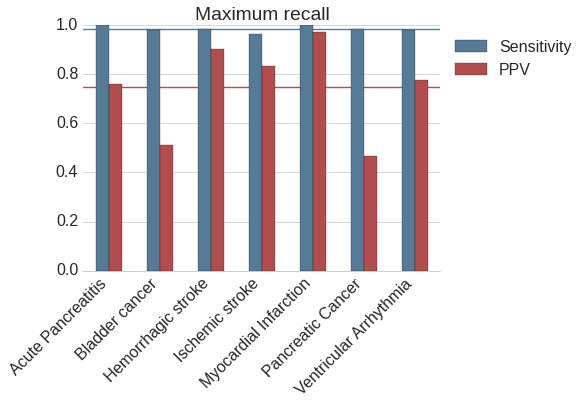

In [84]:
averages_compare = pd.DataFrame([
    ev[ev.variation == 'max-recall'].groupby('event').recall.mean(),
    ev[ev.variation == 'max-recall'].groupby('event').precision.mean(),
])
averages_compare.index = averages_compare.index.map(measure_label)
averages_compare.columns = averages_compare.columns.map(event_names.get)
averages_compare['Average'] = averages_compare.mean(axis=1)

with mystyle(measures_palette, xrot=45, ha='right', savefig='max-recall-by-event.pdf'):
    ax = draw_lines(averages_compare['Average'])
    averages_compare.iloc[:,:-1].T.plot(kind='bar', title="Maximum recall", ax=ax)
averages_compare.round(3)

# Compare relations for expansion

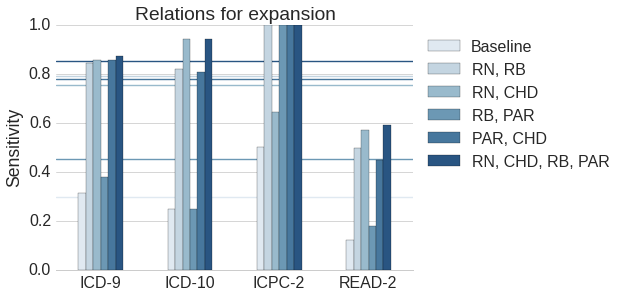

In [85]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-RB.expand', 'RN, RB'),
    ('1-RN-CHD.expand', 'RN, CHD'),
    ('1-RB-PAR.expand', 'RB, PAR'),
    ('1-PAR-CHD.expand', 'PAR, CHD'),
    ('1-RN-CHD-RB-PAR.expand', 'RN, CHD, RB, PAR'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('database').recall.mean()
    for variation in compare_variations
], index=compare_variations)

averages_compare.columns = averages_compare.columns.map(database_label)
averages_compare.index = compare_variations.values()
averages_compare = averages_compare[coding_systems]
averages_compare['Average'] = averages_compare.mean(axis=1)

with mystyle(graded_recall_palette(len(compare_variations), rev=0), savefig='relations-recall-by-db.pdf'):
    ax = draw_lines(averages_compare['Average'])
    averages_compare.iloc[:, :-1].T.plot(kind='bar', title="Relations for expansion", ax=ax)
    plt.ylabel(measure_label('recall'))

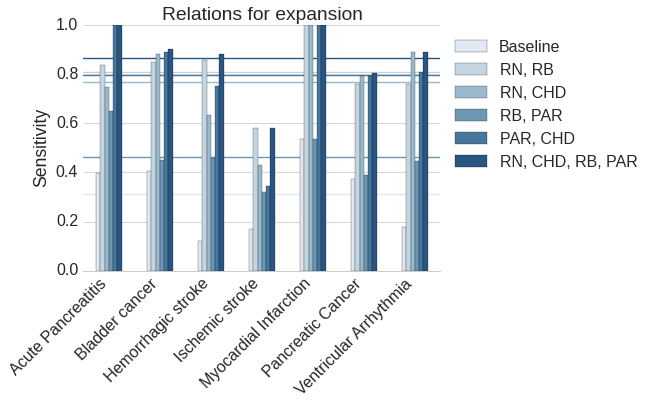

In [86]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-RB.expand', 'RN, RB'),
    ('1-RN-CHD.expand', 'RN, CHD'),
    ('1-RB-PAR.expand', 'RB, PAR'),
    ('1-PAR-CHD.expand', 'PAR, CHD'),
    ('1-RN-CHD-RB-PAR.expand', 'RN, CHD, RB, PAR'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('event').recall.mean()
    for variation in compare_variations
], index=compare_variations)
averages_compare.columns = averages_compare.columns.map(event_names.get)
averages_compare.index = compare_variations.values()
averages_compare['Average'] = averages_compare.mean(axis=1)

with mystyle(graded_recall_palette(len(compare_variations), rev=0), xrot=45, ha='right', savefig='relations-recall-by-event.pdf'):
    ax = draw_lines(averages_compare['Average'])
    averages_compare.iloc[:,:-1].T.plot(kind='bar', title="Relations for expansion", ax=ax)
    plt.ylabel(measure_label('recall'))

# Increasing sensitivity with more expansion steps

,ICD-9,ICD-10,ICPC-2,READ-2,Average
baseline,0.316,0.249,0.5,0.124,0.297
expand$_1$,0.871,0.942,1.0,0.593,0.851
expand$_2$,0.900,1.000,1.0,0.787,0.922
expand$_3$,0.914,1.000,1.0,0.850,0.941
expand$_4$,0.914,1.000,1.0,0.851,0.941


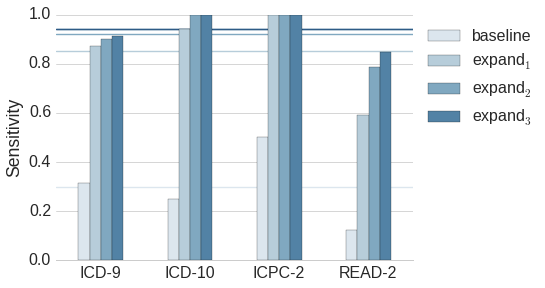

In [136]:
variations_names = OrderedDict([
    ('baseline', 'baseline'),
    ('1-RN-CHD-RB-PAR.expand', 'expand$_1$'),
    ('2-RN-CHD-RB-PAR.expand', 'expand$_2$'),
    ('3-RN-CHD-RB-PAR.expand', 'expand$_3$'),
    ('4-RN-CHD-RB-PAR.expand', 'expand$_4$'),
])
df = pd.DataFrame({
    name: ev[ev.variation == variation].groupby('database').recall.mean()
    for variation, name in variations_names.items()
}).T
df.columns = df.columns.map(database_label)
df = df[coding_systems]
df['Average'] = df.mean(axis=1)

with mystyle(graded_recall_palette(len(variations_names), rev=0), savefig='steps-recall-by-db.pdf'):
    ax = draw_lines(df['Average'])
    df.iloc[:-1,:-1].T.plot(kind='bar', ax=ax)
    plt.ylabel(measure_label('recall'))
    
df.round(3)

## Reasons for low performance in IPCI when including exclusion codes

*Exclusion codes are not in the evaluation any more. See note above.*

The IPCI mapping contains *very* broad codes that are refined with additional terms. For example

- `K24` (Fear of heart attack)
- `K90` (stroke)
- `K93` (Pulmonary embolism)
- `D70` (Dementia) OR "dementia" AND "infarct"
- `U14` (Kidney symptom/complaint ) OR "nier" AND "infarct"

,ICD-9,ICD-10,ICPC-2,READ-2,Average
Baseline,0.514,0.606,0.700,0.458,0.570
Expansion 1 step,0.483,0.518,0.743,0.656,0.600
Expansion 2 steps,0.422,0.461,0.707,0.568,0.539
Expansion 3 steps,0.426,0.455,0.707,0.550,0.534
Expansion 4 steps,0.425,0.454,0.707,0.547,0.533


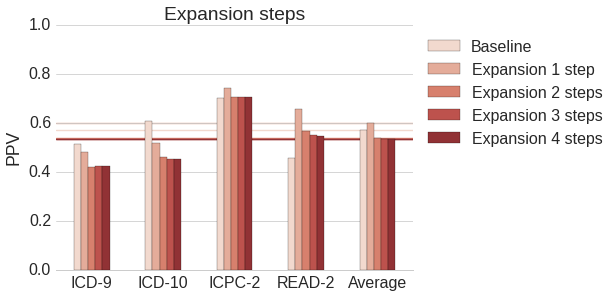

In [137]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-CHD-RB-PAR.expand', 'Expansion 1 step'),
    ('2-RN-CHD-RB-PAR.expand', 'Expansion 2 steps'),
    ('3-RN-CHD-RB-PAR.expand', 'Expansion 3 steps'),
    ('4-RN-CHD-RB-PAR.expand', 'Expansion 4 steps'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('database').precision.mean()
    for variation in compare_variations
], index=compare_variations)
averages_compare.columns = averages_compare.columns.map(database_label)
averages_compare.index = compare_variations.values()
averages_compare = averages_compare[coding_systems]
averages_compare['Average'] = averages_compare.mean(axis=1)

with mystyle(graded_precision_palette(len(compare_variations), rev=0), savefig='steps-precision-by-db.pdf'):
    ax = draw_lines(averages_compare['Average'])
    averages_compare.T.plot(kind='bar', title="Expansion steps", ax=ax)
    plt.ylabel(measure_label('precision'))
averages_compare.round(3)

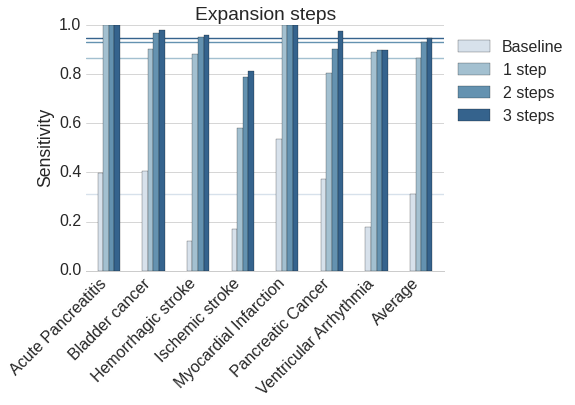

In [89]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-CHD-RB-PAR.expand', '1 step'),
    ('2-RN-CHD-RB-PAR.expand', '2 steps'),
    ('3-RN-CHD-RB-PAR.expand', '3 steps'),
#    ('4-RN-CHD-RB-PAR.expand', '4 steps'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('event').recall.mean()
    for variation in compare_variations
], index=compare_variations)
averages_compare.columns = averages_compare.columns.map(event_names.get)
averages_compare.index = compare_variations.values()
averages_compare['Average'] = averages_compare.mean(axis=1)

with mystyle(graded_recall_palette(len(compare_variations), rev=0), xrot=45, ha='right', savefig='steps-recall-by-event.pdf'):
    ax = draw_lines(averages_compare['Average'])
    averages_compare.T.plot(kind='bar', title="Expansion steps", ax=ax)
    plt.ylabel(measure_label('recall'))

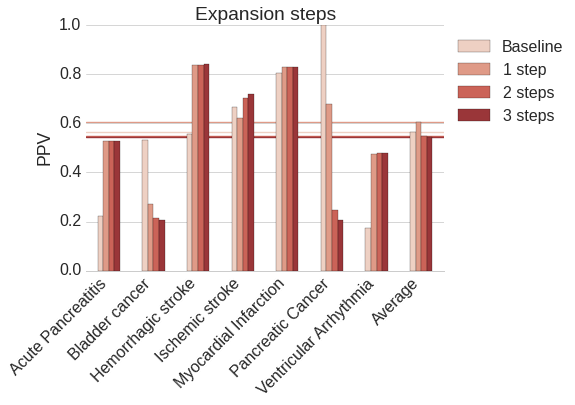

In [90]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-CHD-RB-PAR.expand', '1 step'),
    ('2-RN-CHD-RB-PAR.expand', '2 steps'),
    ('3-RN-CHD-RB-PAR.expand', '3 steps'),
#    ('4-RN-CHD-RB-PAR.expand', '4 steps'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('event').precision.mean()
    for variation in compare_variations
], index=compare_variations)
averages_compare.columns = averages_compare.columns.map(event_names.get)
averages_compare.index = compare_variations.values()
averages_compare['Average'] = averages_compare.mean(axis=1)

with mystyle(graded_precision_palette(len(compare_variations), rev=0), xrot=45, ha='right', savefig='steps-precision-by-event.pdf'):
    ax = draw_lines(averages_compare['Average'])
    averages_compare.T.plot(kind='bar', title="Expansion steps", ax=ax)
    plt.ylabel(measure_label('precision'))

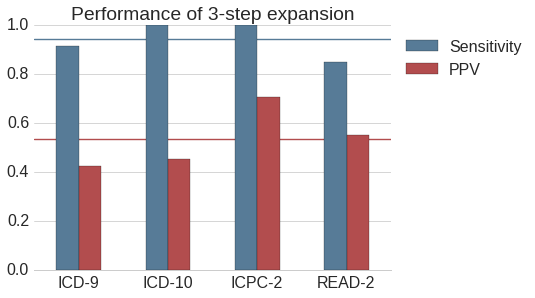

In [91]:
measures = ['recall', 'precision']
averages_compare = pd.DataFrame([
    ev[ev.variation == '3-RN-CHD-RB-PAR.expand'].groupby('database')[measure].mean()
    for measure in measures
], index=map(measure_label, measures))
averages_compare.columns = averages_compare.columns.map(database_label)
averages_compare = averages_compare[coding_systems]
averages_compare['Average'] = averages_compare.mean(axis=1)

name = 'expansion3-performance-by-db'
with mystyle(measures_palette, savefig=name+'.pdf'):
    ax = draw_lines(averages_compare['Average'])
    averages_compare.iloc[:,:-1].T.plot(kind='bar', title="Performance of 3-step expansion", ax=ax)
averages_compare.to_csv(name+'.csv')

# FN error-analysis

In [129]:
variation = '3-RN-CHD-RB-PAR.expand'

with open("../{}.{}.error-analyses.yaml".format(PROJECT, variation)) as f:
    error_analyses = yaml.load(f)
    
def get_category(fn_or_fp, database, event, code):
    if database in error_analyses[fn_or_fp] and event in error_analyses[fn_or_fp][database]:
        return error_analyses[fn_or_fp][database][event]['code-categories'].get(code) or '?'
    else:
        return '??'

evs = ev[(ev.variation == variation) & ev.fn.notnull()][['event', 'database', 'fn', 'fp']]

fn = evs.apply(lambda row: pd.Series(row.fn), axis=1).stack().reset_index(level=1, drop=True)
fn.name = 'code'
# fns : | event | database | code |
fns = evs.drop(['fn', 'fp'], axis=1).join(fn, how='inner').drop_duplicates()
fns['category'] = fns.apply(lambda r: get_category('fn', r.database, r.event, r.code), axis=1)

fp = evs.apply(lambda row: pd.Series(row.fp), axis=1).stack().reset_index(level=1, drop=True)
fp.name = 'code'
# fps : | event | database | code |
fps = evs.drop(['fn', 'fp'], axis=1).join(fp, how='inner').drop_duplicates()
fps['category'] = fps.apply(lambda r: get_category('fp', r.database, r.event, r.code), axis=1)

fns.groupby(['category', 'database']).code.aggregate(lambda s: set(s)).map(', '.join).to_frame()

code
category          database                                                                                                  
database-specific CPRD             70082, 853.., 3283., 70043, 7L1H4, 7L1Hy, 70041, 7L1Hz, 7L1H., 8532., 8531., 853Z., 70042
                  Medicare                                                    433.11, 433.01, 433.21, 433.81, 434.01, 433.31
next-expansion    CPRD                                                                            BB5Cz, BB44., BB5C., B8086
not-in-dnf        CPRD      G6X.., 1O0.., 7L1H6, BA0z., G6W.., BBaz., ByuE0, G60X., G64z4, 7L1H7, BBd9., BBa.., ByuE., G61X.

In [130]:
fps.groupby(['category', 'database']).code.aggregate(lambda s: set(s)).map(', '.join).to_frame()

code
category database                                                                                                     
in-dnf   CPRD      BBc9z, BBCz., BBC.., BBC10, Nyu8., BB30., B33z., BBn2., B151z, B554., B5504, BBFz., BBb5., B62y....
         GePaRD    C85.9, C17.9, K62.82, K92, C76.4, C4A, C44, C57.9, I46, D23, D32.9, C76.8, C76.5, C79.2, C90.3, ...
         IPCI                                                                                       U75, S77, A79, N74
         Medicare  239.89, 176, 184.9, 195.4, 198.2, 234.8, 236, 197.4, 233.5, 195.5, 235.5, 432, 233, 239, 569.44,...
other-fp CPRD      J67.., R1043, 1B6.., 22JZ., G57z., R050., G8y0., R090z, 6652., 32K3., B7D3., R090., J671., R0003...
         GePaRD    K86.1, K86.9, C73.-C75.9, C45.-C49, C64.-C68.9, C73.-C75, I49.9, C15.-C26.9, R00.1, R00.0, R40.2...
         IPCI                                                                                                      K80
         Medicare  427, 230.-234.99, 239.-239.99, 190.-199.99, 209.-209.99, 570.-579.99, 789.0, 179.-189.99, 785.0,...

In [134]:
code_counts = pd.Series({
    database: len(set(mappings.all_codes(database)))
    for database in databases.databases()
})
code_counts.ix['All'] = code_counts.sum()
code_counts.index.name = 'database'

def category_label(category):
    return {
        # FN
        'not-in-dnf': 'Not in UMLS',
        'database-specific': 'DB specific',
        'next-expansion': 'expansion_{4}',
        'isolated': 'Isolated',
        # FP
        'in-dnf': 'Cosynonym',
        'other-fp': 'Indexing FP',
    }.get(category, category)

def counts(code_categories, FN_or_FP):
    "code_categories : | code | category |"
    # (database, category) | int
    s1 = code_categories.groupby('database').category.value_counts()
    # category | int
    s2 = code_categories.category.value_counts()
    s2.index = pd.MultiIndex.from_product([['Overall'], s2.index])
    res = pd.concat([s1, s2]).to_frame('count')
    res['%'] = (res['count'] / s2.sum()).map('{:.1%}'.format)
    #res['% (mapping)'] = (res['count'] / code_counts).map('{:.1%}'.format)

    res = res.rename(columns={'count': '{} category'.format(FN_or_FP)}).reset_index()
    res['category'] = res['category'].map(category_label)
    res['database'] = res['database'].map(lambda db: db if db == 'Overall' else database_label(db))
    return res

counts(fps, 'FP')

,database,category,FP category,%
0,READ-2,Cosynonym,394,53.5%
1,READ-2,Indexing FP,20,2.7%
2,ICD-10,Cosynonym,152,20.6%
3,ICD-10,Indexing FP,47,6.4%
4,ICPC-2,Cosynonym,7,0.9%
5,ICPC-2,Indexing FP,1,0.1%
6,ICD-9,Cosynonym,91,12.3%
7,ICD-9,Indexing FP,25,3.4%
8,Overall,Cosynonym,644,87.4%
9,Overall,Indexing FP,93,12.6%


In [135]:
counts(fns, 'FN')

,database,category,FN category,%
0,READ-2,Not in UMLS,21,47.7%
1,READ-2,DB specific,13,29.5%
2,READ-2,expansion_{4},4,9.1%
3,ICD-9,DB specific,6,13.6%
4,Overall,Not in UMLS,21,47.7%
5,Overall,DB specific,19,43.2%
6,Overall,expansion_{4},4,9.1%


```
measures = OrderedDict([
    ('recall', measure_label('recall')),
    ('recall_in_umls', '{} to reference in UMLS'.format(measure_label('recall'))),
    ('recall_without_exclusions', '{} over inclusion codes'.format(measure_label('recall'))),
    ('recall_without_exclusions_in_umls', '{} over inclusion codes in UMLS'.format(measure_label('recall'))),
    ('', ''),
    ('precision', measure_label('precision')),
    ('precision_over_dnf', '{} over maximum recall'.format(measure_label('precision'))),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == '3-RN-CHD-RB-PAR.expand'].groupby('database')[measure].mean()\
        if measure else\
        pd.Series([0] * len(ev.database.unique()), index=ev.database.unique())
    for measure in measures
], index=measures.values())
averages_compare.columns = averages_compare.columns.map(database_label)

p = sns.color_palette(graded_recall_palette(5)[:-1] + [(1,1,1)] + graded_precision_palette(3)[:-1])
with mystyle(p, savefig='expansion3-error-analysis-by-db.pdf'):
    averages_compare.T.plot(kind='bar', title="Error analysis of 3-step expansion")
```

```
averages_compare = pd.DataFrame([
    ev[ev.variation == '3-RN-CHD-RB-PAR.expand'].groupby('event')[measure].mean()\
        if measure else\
        pd.Series([0] * len(ev.event.unique()), index=ev.event.unique())
    for measure in measures
], index=measures.values())
averages_compare.columns = averages_compare.columns.map(event_label)

p = sns.color_palette(graded_recall_palette(5)[:-1] + [(1,1,1)] + graded_precision_palette(3)[:-1])
with mystyle(p, savefig='expansion3-error-analysis-by-db.pdf', xrot=45, ha='right'):
    averages_compare.T.plot(kind='bar', title="Error analysis of 3-step expansion")
```

```
residuals = ev[ev.variation == '3-RN-CHD-RB-PAR.expand']


residuals.fn_inclusions_in_umls = residuals.fn_inclusions_in_umls\
    .fillna('NaN').map(json.loads)
def get_missed(row):
    if math.isnan(row.recall_without_exclusions_in_umls):
        return ''
    else:
        reference = set(json.loads(row.reference_inclusions_in_umls))
        return "{}/{}".format(len(row.fn_inclusions_in_umls), len(reference))
                                     
residuals['missed'] = residuals.apply(get_missed, axis=1)

residuals.fn_inclusions_in_umls = residuals.fn_inclusions_in_umls\
    .map(lambda s: ', '.join(s) if type(s) == list else 'N/A')
residuals.database = residuals.database.map(database_label)
residuals.event = residuals.event.map(event_label)
residuals.recall_without_exclusions_in_umls = residuals.recall_without_exclusions_in_umls\
    .map('{:.2f}'.format)
residuals = residuals.sort_index(by=['database', 'event']).reset_index(drop=True)
    
residuals = residuals[['database', 'event', 'recall_without_exclusions_in_umls', 'missed', 'fn_inclusions_in_umls']]
residuals.columns = ["Database", "Event", "Recall", "Missed", "Residual FNs"]

#residuals = residuals.set_index(['Database', 'Event'])["Residual FNs"].unstack()
residuals
```

# Removing unused codes

```python
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('baseline.filter-gen', 'Filtered'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('database').precision.mean()
    for variation in compare_variations
], index = compare_variations.values())
averages_compare.columns = averages_compare.columns.map(database_label)

with mystyle(graded_precision_palette(len(compare_variations)), savefig='filtered-baseline-precision-by-db.pdf'):
    averages_compare.T.plot(kind='bar', title="Filtered baseline")
    plt.ylabel(measure_label('precision'))
```
```python
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('baseline.filter-gen', 'Filtered'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('event').precision.mean()
    for variation in compare_variations
], index = compare_variations.values())
averages_compare.columns = averages_compare.columns.map(event_label)

with mystyle(graded_precision_palette(len(compare_variations)), xrot=45, ha='right', savefig='filtered-baseline-precision-by-event.pdf'):
    averages_compare.T.plot(kind='bar', title="Filtered baseline")
    plt.ylabel(measure_label('precision'))
```
```python
compare_variations = OrderedDict([
    ('3-RN-CHD-RB-PAR.expand', 'Expand 3 steps'),
    ('3-RN-CHD-RB-PAR.expand.filter-gen', 'Expand 3 steps, filter'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('database').precision.mean()
    for variation in compare_variations
], index = compare_variations.values())
averages_compare.columns = averages_compare.columns.map(database_label)

with mystyle(graded_precision_palette(len(compare_variations)), savefig='filtered-expansion3-precision-by-db.pdf'):
    averages_compare.T.plot(kind='bar', title="Filtered expansion")
    plt.ylabel(measure_label('precision'))
```
```python
compare_variations = OrderedDict([
    ('3-RN-CHD-RB-PAR.expand', 'Expand 3 steps'),
    ('3-RN-CHD-RB-PAR.expand.filter-gen', 'Expand 3 steps, filter'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('event').recall.mean()
    for variation in compare_variations
], index = compare_variations.values())
averages_compare.columns = averages_compare.columns.map(event_names.get)

with mystyle(graded_recall_palette(len(compare_variations)), xrot=45, ha='right', savefig='filtered-expansion3-recall-by-event.pdf'):
    averages_compare.T.plot(kind='bar', title="Filtered 3-step expansion")
    plt.ylabel(measure_label('recall'))
```
```python
compare_variations = OrderedDict([
    ('3-RN-CHD-RB-PAR.expand', 'Expand 3 steps'),
    ('3-RN-CHD-RB-PAR.expand.filter-gen', 'Expand 3 steps, filter'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('event').precision.mean()
    for variation in compare_variations
], index = compare_variations.values())
averages_compare.columns = averages_compare.columns.map(event_names.get)

with mystyle(graded_precision_palette(len(compare_variations)), xrot=45, ha='right', savefig='filtered-expansion3-precision-by-event.pdf'):
    averages_compare.T.plot(kind='bar', title="Filtered 3-step expansion")
    plt.ylabel(measure_label('precision'))
```
```python
measures = ['recall', 'precision']
averages_compare = pd.DataFrame([
    ev[ev.variation == '3-RN-CHD-RB-PAR.expand.filter-gen'].groupby('database')[measure].mean()
    for measure in measures
], index=map(measure_label, measures))
averages_compare.columns = averages_compare.columns.map(database_label)
#averages_compare.index = compare_variations.values()

with mystyle(measures_palette, savefig='filtered-expansion3-performance-by-db.pdf'):
    averages_compare.T.plot(kind='bar', title="Performance of filtered 3-step expansion")
```

The drop in PPV for Myocardial infarction is caused by the mapping to codes `410.*` (Acute myocardial infarction) in Medicare which is *not* used in the ARS database.

# Codes in reference mappings, not in databases
Codes that might be removed from the TP when filtering.

```python
stats = DataFrame()
stats['In ref'] = code_stats[code_stats.InMapping]\
    .groupby('Database').Code.count()
stats['Not in DB'] = code_stats[code_stats.InMapping & ~code_stats.InDatabase]\
    .groupby('Database').Code.count()
stats.fillna(0, inplace=True)
stats['%'] = (stats['Not in DB'] / stats['In ref']).map("{:.2%}".format)
stats['Codes'] = code_stats[code_stats.InMapping & ~code_stats.InDatabase]\
    .groupby('Database').Code.aggregate(lambda vs: ', '.join(set(vs)))
stats
```